<a href="https://colab.research.google.com/github/Felipe0042/Felipe_data_science/blob/main/Projeto_analise_consumo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pylab
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist, pdist
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import seaborn as sn 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from itertools import cycle
from scipy.spatial.distance import cdist, pdist


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
datatest = pd.read_csv('/content/drive/MyDrive/MBA-USP/DSA-CursoMachineLearning/Curso_Data_Science-Machine_Learning/Capitulo_10- Clustering/Python-Script/household_power_consumption.txt', delimiter = ';', low_memory = False)
datatest.head()

,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,16/12/2006,17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
1,16/12/2006,17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2,16/12/2006,17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
3,16/12/2006,17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
4,16/12/2006,17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


### Extraindo 10% dos dados de forma aleatória 

In [3]:
indices_aleatorios  = np.random.permutation(len(datatest))
tamanho_dados = int(len(datatest)*0.005)
indices_dados = indices_aleatorios[:tamanho_dados]


#retirando as colunas index, date e time 
dados = datatest.iloc[indices_dados].reset_index()
dados = dados.drop(['index', 'Date', 'Time'], axis = 1)

### Retirando valores "?" e convertendo para numérico

In [4]:
dados = dados[dados['Global_active_power'] != '?']

In [5]:
def converter_float(coluna):
  dados[coluna] = dados[coluna].replace(',','.')
  dados[coluna] = dados[coluna].astype(float)

  return dados[coluna]

In [6]:
for colunas in dados.columns:
  converter_float(colunas)

### Visualizando as correlações 

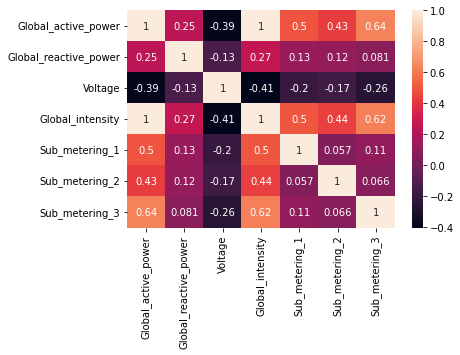

In [7]:
sn.heatmap(dados.corr(), annot=True)

### Padronizando os dados 

In [8]:
scaler = StandardScaler()

dados_padronizados = scaler.fit(dados)
dados_padronizados = dados_padronizados.transform(dados)
dados_padronizados = pd.DataFrame(dados_padronizados, columns= dados.columns)

In [9]:
dados_padronizados.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
0,0.191021,-1.093302,-0.566832,0.167517,-0.185487,-0.223845,1.354824
1,-0.767817,-0.298424,1.334795,-0.774932,-0.185487,-0.223845,-0.771488
2,-0.837654,-0.316088,0.613698,-0.819811,-0.185487,-0.223845,-0.771488
3,-0.905603,-1.093302,0.285097,-0.909568,-0.185487,-0.223845,-0.653360
4,0.385431,0.249158,-2.319372,0.391910,-0.026107,-0.056809,1.236696


### Usando PCA para diminuir a dimensionalidade do banco de dados 

In [10]:
pca = PCA(n_components=2).fit(dados_padronizados)

componente1 = round(pca.explained_variance_ratio_[0], 2)
componente2 = round(pca.explained_variance_ratio_[1], 2)

In [11]:
pca = pca.transform(dados_padronizados)

### Verificando o melhor K pela curva elbow da inercia 

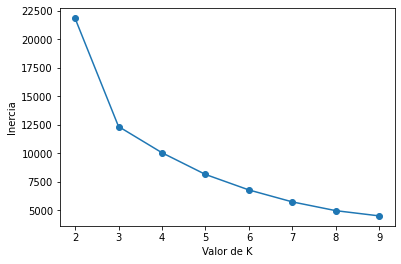

In [12]:
#Inercia - Soma das distâncias das amostras para o seu centro de agrupamento mais proximo

Ks = range(2,10)

valores_metrica = []

for K in Ks:
  modelo = KMeans(n_clusters=K, random_state=101)
  modelo.fit(pca)
  valores_metrica.append(modelo.inertia_)

plt.plot(Ks, valores_metrica, 'o-')
plt.xlabel('Valor de K')
plt.ylabel('Inercia')
plt.show()

### Verificando o melhor K pela curva Elbow da variância explicada

In [ ]:
k_range = range(1,12)

#criando um modelo para cada valor de K
modelo_para_k = [KMeans(n_clusters=k).fit(pca) for k in k_range]

#determinando os centros 
centros = [X.cluster_centers_ for X in modelo_para_k]

#calculando a distancia euclidiana para cada ponto de dados para o centroide
distancia_centro = [cdist(pca, cent, 'euclidean') for cent in centros]
dist_minima = [np.min(ke, axis=1) for ke in distancia_centro]


#Soma dos quadrados das distâncias dentro do cluster
soma_quadrados_intra_cluster = [sum(d**2) for d in dist_minima]

In [ ]:
#Soma total dos quadrados
soma_total = sum(pdist(pca)**2)/pca.shape[0]

In [ ]:
#soma entre cluster
soma_quadrados_inter_cluster = soma_total - soma_quadrados_intra_cluster

Text(0.5, 1.0, 'Variância Explicada x Número cluster')

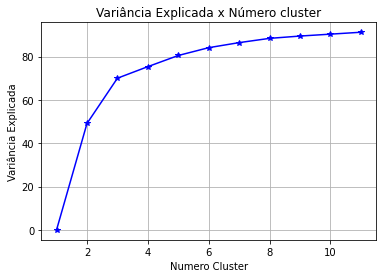

In [ ]:
plt.plot(k_range, soma_quadrados_inter_cluster/soma_total * 100, 'b*-')
plt.grid(True)
plt.xlabel('Numero Cluster')
plt.ylabel('Variância Explicada')
plt.title('Variância Explicada x Número cluster')

### Usando com o k escolhido

In [14]:
numero_cluster = 3

In [16]:
modelo_3k = KMeans(n_clusters= numero_cluster, init = 'random', random_state=101)
modelo_3k.fit(pca)

KMeans(algorithm='auto', copy_x=True, init='random', max_iter=300, n_clusters=3,
       n_init=10, n_jobs=None, precompute_distances='auto', random_state=101,
       tol=0.0001, verbose=0)

In [25]:
dados['labels'] = modelo_3k.labels_

### Silhouette score

In [23]:
labels = modelo_3k.labels_
silhouette_score(pca, labels, 'euclidean')

0.5744046397686197

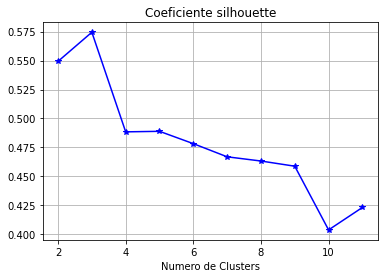

In [13]:
ks = np.arange(2,12)

modelos = [KMeans(n_clusters=k) for k in ks]
labelsmodelos = [modelo.fit(pca).labels_ for modelo in modelos]
silhouette_scores = [silhouette_score(pca, label, 'euclidean') for label in labelsmodelos]

plt.plot(ks, silhouette_scores, 'b*-')
plt.grid(True)
plt.title('Coeficiente silhouette')
plt.xlabel('Numero de Clusters')
plt.show()

### Plotar modelo

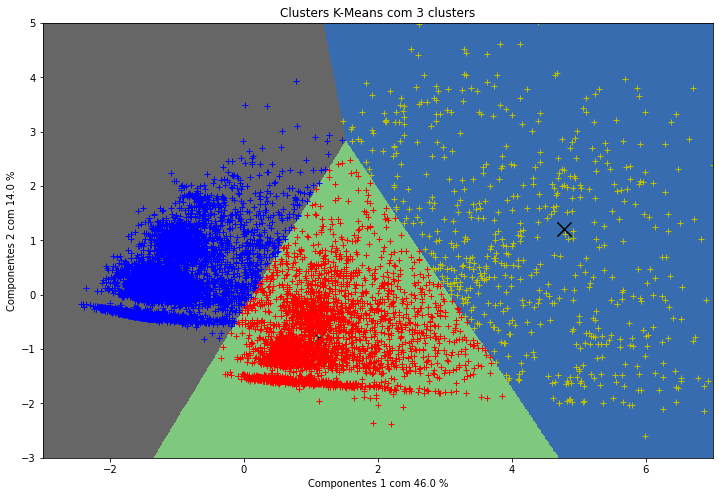

In [29]:
plt.figure(figsize=(12,8))


cores_ = 'rybrcmykb'
colors = cycle(cores_[:numero_cluster])

for i in range(0, pca.shape[0]):

  # Plotando os dados referente a cada label do cluster original
  for label, col in zip(range(len(pd.unique(modelo_3k.labels_))), colors):
    if modelo_3k.labels_[i] == label:
      plt.plot(pca[i,0], pca[i,1], col + '.', marker = '+')

delta = 0.01
x_min, x_max = pca[:, 0].min() - 5, pca[:, 0].max() - 1
y_min, y_max = pca[:, 1].min() - 2, pca[:, 1].max() + 5

xx, yy = np.meshgrid(np.arange(x_min, x_max, delta),np.arange(y_min, y_max, delta))

Z = modelo_3k.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

plt.imshow(Z,
           interpolation = 'nearest',
           extent = (xx.min(), xx.max(), yy.min(), yy.max()),
           cmap = plt.cm.Accent,
           aspect = 'auto',
           origin = 'lower')


plt.axis([-3,7,-3,5])

plt.scatter(modelo_3k.cluster_centers_[:,0], modelo_3k.cluster_centers_[:,1], marker = 'x', linewidths=2, s = 200, color = 'k')
plt.title('Clusters K-Means com %d clusters' % (len(pd.unique(modelo_3k.labels_))))
plt.xlabel('Componentes 1 com {:.1f} %'.format(componente1*100))
plt.ylabel('Componentes 2 com {:.1f} %'.format(componente2*100))
plt.show()

In [26]:
valores_medios = {}
for i in range(0, (len(pd.unique(modelo_3k.labels_)))):
  valores_medios['Grupo ' + str(i) + ' Consumo medio em kW'] = round(dados[dados['labels'] == i]['Global_active_power'].mean(), 2)

In [36]:
diferencas = pd.DataFrame(dados.groupby('labels')['Global_active_power'].mean().sort_values())

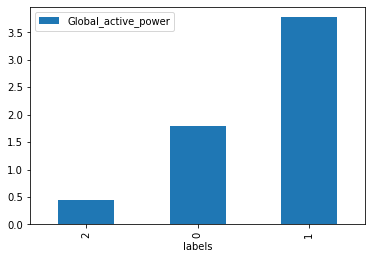

In [42]:
diferencas.plot(kind = 'bar')